In [52]:
#!/usr/bin/env python
# coding: utf-8

#import scienceplots
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
import corner

from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler

from helpers.composite_helpers import *

plt.style.use("science.mplstyle")

#plt.style.use('science')
dpi = 800

In [53]:
feta_dir = "/clusterfs/ml4hep/rrmastandrea/FETA"
scatterplot_dir = os.path.join(feta_dir, "scatterplot_all_synth_samples")

## Visualize the scatterplots 

First run ```run_scatterplot.py```

In [80]:
# Load in the data



num_signal_to_inject = 1200
process = "IsotonicReg"


synth_ids = ["feta", "cathode", "curtains", "fullsup"]#, "combined"]

all_results_bkg = {iid:{} for iid in synth_ids}
all_results_sig = {iid:{} for iid in synth_ids}


def standardize(x):
    return (x - np.mean(x))/np.std(x)

n_seed = 5

for iid in synth_ids:
    for seed_NN in range(n_seed):
        
        if iid != "fullsup":
            data = np.load(f"{scatterplot_dir}/{iid}_results_seedNN{seed_NN}_nsig{num_signal_to_inject}.npy")
        else:
            data = np.load(f"{scatterplot_dir}/full_sup_results_seedNN{seed_NN}.npy")
        
        # currently standardizing each random seed independently. May want to revisit!
        if process == "StandardScale":
            data_stand = StandardScaler().fit_transform(data)
            
        elif process == "IsotonicReg":
            true_labels = np.concatenate((np.zeros((20000,)), np.ones((20000,))))
            data_stand = IsotonicRegression().fit_transform(data, true_labels).reshape(-1, 1)
        elif process == "None":
            data_stand = data
            
        data_bkg = data_stand[:20000]
        data_sig = data_stand[20000:]
        
        all_results_bkg[iid][seed_NN] = data_bkg
        all_results_sig[iid][seed_NN] = data_sig
    

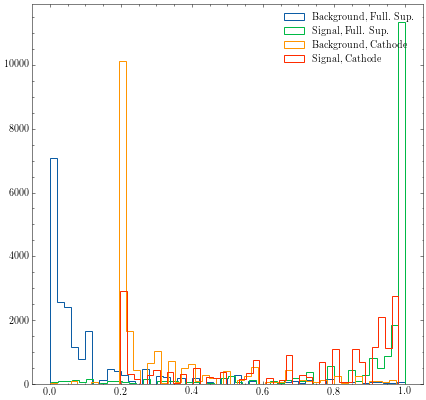

In [81]:
# Make sure that the first half is background, second half is signal

plt.figure()
plt.hist(all_results_bkg["fullsup"][3], bins = 50, histtype = "step", label = "Background, Full. Sup.")
plt.hist(all_results_sig["fullsup"][3], bins = 50, histtype = "step", label = "Signal, Full. Sup.")


plt.hist(all_results_bkg["cathode"][3], bins = 50, histtype = "step", label = "Background, Cathode")
plt.hist(all_results_sig["cathode"][3], bins = 50, histtype = "step", label = "Signal, Cathode")


plt.legend()
plt.show()


## Plot samples against each other for all random seeds

In [82]:
# concatenate results

concatenated_results_bkg = {iid:0 for iid in synth_ids}
concatenated_results_sig = {iid:0 for iid in synth_ids}




for iid in synth_ids:
    loc_holder_bkg = np.empty((0, 1))
    loc_holder_sig = np.empty((0, 1))
    
    for seed_NN in range(n_seed):
        loc_holder_bkg = np.concatenate((loc_holder_bkg, all_results_bkg[iid][seed_NN]), axis = 0)
        loc_holder_sig = np.concatenate((loc_holder_sig, all_results_sig[iid][seed_NN]), axis = 0)
        
    concatenated_results_bkg[iid] = loc_holder_bkg
    concatenated_results_sig[iid] = loc_holder_sig


In [83]:
import matplotlib.colors as colors

def make_plot(bkg_x, bkg_y, sig_x, sig_y, label_x, label_y, num_bins = 100, plot_lims = 5, vmax = 5e3):
    
    # plot params
    b = np.linspace(-plot_lims, plot_lims, num_bins)
    cmap = "rainbow"
    fontsize = 30
    small_font = 20


    fig, ax = plt.subplots(1, 2, figsize = (16, 8))

    img_bkg = ax[0].hist2d(bkg_x.flatten(), bkg_y.flatten(), bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, density = False)
    ax[0].plot([-plot_lims, plot_lims], [-plot_lims, plot_lims], color = "black")
    ax[0].set_xlabel(label_x, fontsize = fontsize)
    ax[0].set_ylabel(label_y, fontsize = fontsize)
    ax[0].set_title("Background", fontsize = fontsize)
    ax[0].set_aspect(1)
    ax[0].text(-3, 4, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}", fontsize = fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=small_font)
    

    img_sig = ax[1].hist2d(sig_x.flatten(), sig_y.flatten(), bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, density = False)
    ax[1].plot([-plot_lims, plot_lims], [-plot_lims, plot_lims], color = "black")
    ax[1].set_xlabel(label_x, fontsize = fontsize)
    ax[1].set_ylabel(label_y, fontsize = fontsize)
    ax[1].set_title("Signal", fontsize = fontsize)
    ax[1].set_aspect(1)
    ax[1].text(-3, 4, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}", fontsize = fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=small_font)
    
    cb_ax = fig.add_axes([.92,.2,.02,.6])
    cbar = fig.colorbar(img_sig[3],orientation='vertical',cax=cb_ax)


    cbar.ax.tick_params(labelsize=small_font, rotation = 270) 
    cbar.set_label("Counts", fontsize = small_font, rotation = 270, labelpad = 20)

    plt.show()
    return fig


In [ ]:
dim = len(synth_ids)

#params for all plots
num_bins = 60
lower_plot_lim, upper_plot_lim = -0.1, 1.1
vmax = 5e3
b = np.linspace(lower_plot_lim, upper_plot_lim, num_bins)
cmap = "rainbow"
fontsize = 25
small_font = 20


nice_labels = ["FETA", "CATHODE", "CURTAINs", "Full. Sup"]


fig, ax = plt.subplots(dim, dim, figsize = (4*dim, 4*dim))

for dim_x in range(dim):
    for dim_y in range(dim):
        
        if dim_x < dim_y: # plot the 2d hist
            img_bkg = ax[dim_y, dim_x].hist2d(concatenated_results_bkg[synth_ids[dim_x]].flatten(), 
                                          concatenated_results_bkg[synth_ids[dim_y]].flatten(), 
                                          bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, 
                                          density = False)
            ax[dim_y, dim_x].plot([-plot_lims, plot_lims], [-plot_lims, plot_lims], color = "black")
            
        
        elif dim_x == dim_y: # plot the 1d hist
            ax[dim_x, dim_x].hist(concatenated_results_bkg[synth_ids[dim_x]].flatten(), bins = b, histtype = "step")
            ax[dim_x, dim_x].set_yscale("log")
            
        else:
            ax[dim_y, dim_x].set_axis_off()
            
        # axis labels
        if dim_y == dim - 1:
            ax[dim_y, dim_x].set_xlabel(nice_labels[dim_x], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='x', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_xticks([])
        if (dim_x == 0) and (dim_y != 0):
            ax[dim_y, dim_x].set_ylabel(nice_labels[dim_y], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='y', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_yticks([])
            
# label
ax[0, 2].text(0, .5, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}\nBackground events", fontsize = fontsize)

# colorbar (they all have the same one)
cb_ax = fig.add_axes([.82,.34,.02,.4])
cbar = fig.colorbar(img_bkg[3],orientation='vertical',cax=cb_ax)

cbar.ax.tick_params(labelsize=small_font, rotation = 270) 
cbar.set_label("Counts", fontsize = small_font, rotation = 270, labelpad = 20)

        

            

plt.tight_layout()
fig.show()


fig.savefig(f"paper_plots/corner_bkg_{num_signal_to_inject}.pdf", dpi = dpi)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


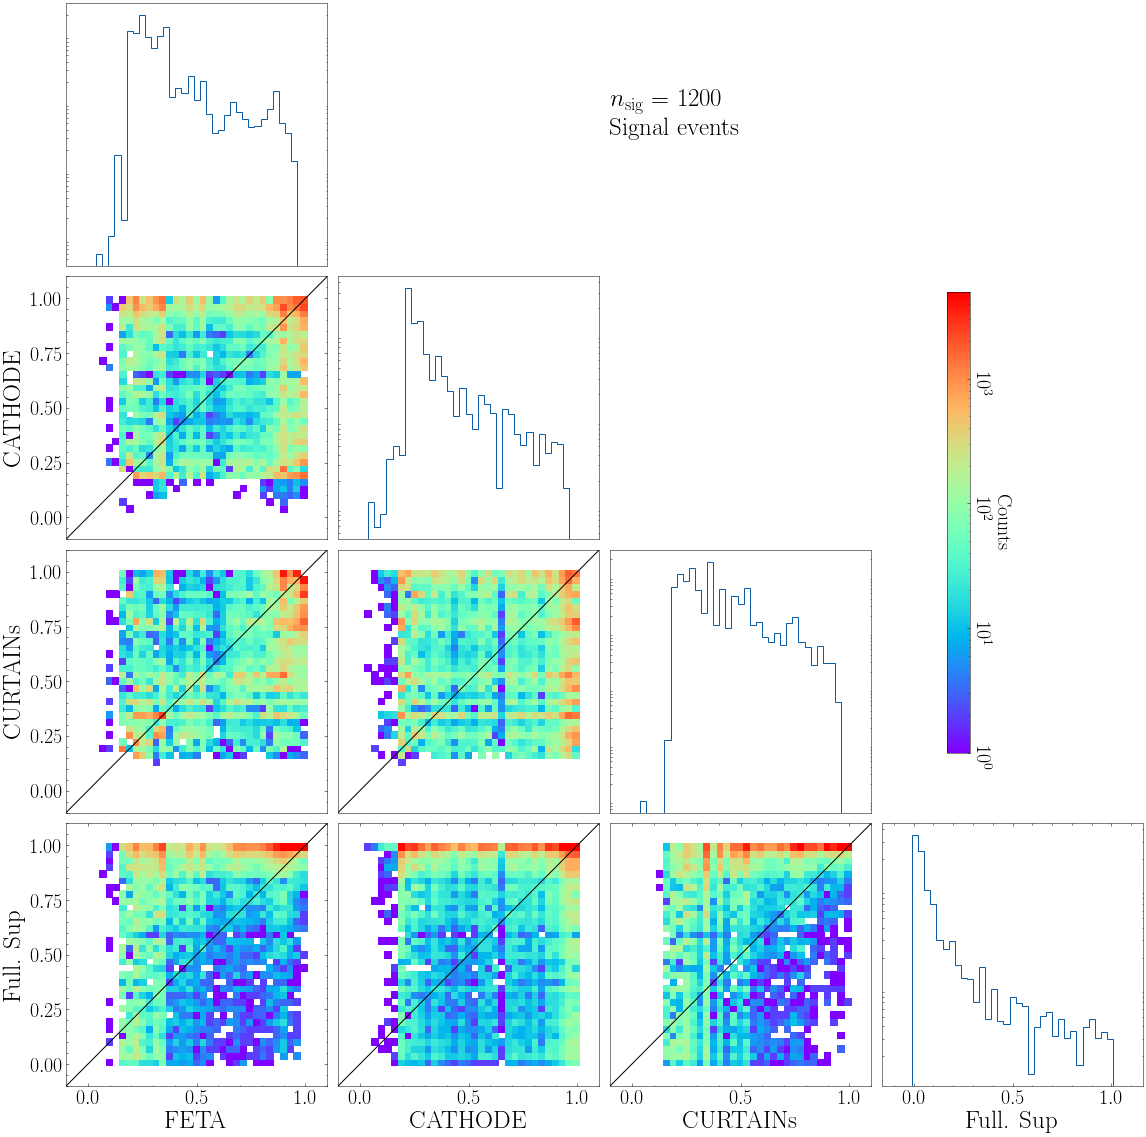

In [88]:

#params for all plots
num_bins = 40
lower_plot_lim, upper_plot_lim = -0.1, 1.1
vmax = 5e3
b = np.linspace(lower_plot_lim, upper_plot_lim, num_bins)
cmap = "rainbow"
fontsize = 25
small_font = 20





fig, ax = plt.subplots(dim, dim, figsize = (4*dim, 4*dim))



for dim_x in range(dim):
    for dim_y in range(dim):
        
        if dim_x < dim_y: # plot the 2d hist
            img_sig = ax[dim_y, dim_x].hist2d(concatenated_results_sig[synth_ids[dim_x]].flatten(), 
                                          concatenated_results_sig[synth_ids[dim_y]].flatten(), 
                                          bins = b, norm=colors.LogNorm(vmin=1e0, vmax=vmax), cmap = cmap, 
                                          density = False)
            ax[dim_y, dim_x].plot(b, b, color = "black")
            
        
        elif dim_x == dim_y: # plot the 1d hist
            ax[dim_x, dim_x].hist(concatenated_results_bkg[synth_ids[dim_x]].flatten(), bins = b, histtype = "step")
            ax[dim_x, dim_x].set_yscale("log")
            
        else:
            ax[dim_y, dim_x].set_axis_off()
            
        # axis labels
        if dim_y == dim - 1:
            ax[dim_y, dim_x].set_xlabel(nice_labels[dim_x], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='x', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_xticks([])
        if (dim_x == 0) and (dim_y != 0):
            ax[dim_y, dim_x].set_ylabel(nice_labels[dim_y], fontsize = fontsize)
            ax[dim_y, dim_x].tick_params(axis='y', which='major', labelsize=small_font)
        else:
            ax[dim_y, dim_x].set_yticks([])
            
# label
ax[0, 2].text(0, .5, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}\nSignal events", fontsize = fontsize)

# colorbar (they all have the same one)
cb_ax = fig.add_axes([.82,.34,.02,.4])
cbar = fig.colorbar(img_sig[3],orientation='vertical',cax=cb_ax)

cbar.ax.tick_params(labelsize=small_font, rotation = 270) 
cbar.set_label("Counts", fontsize = small_font, rotation = 270, labelpad = 20)



            

plt.tight_layout()
fig.show()

fig.savefig(f"paper_plots/corner_sig_{num_signal_to_inject}.pdf", dpi = dpi)


## Plot one method's samples against each other for different random seeds

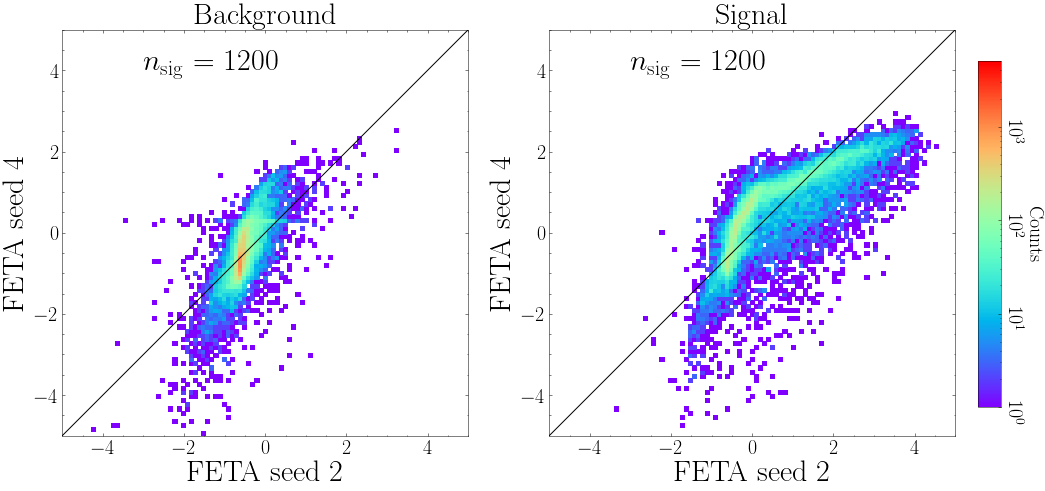

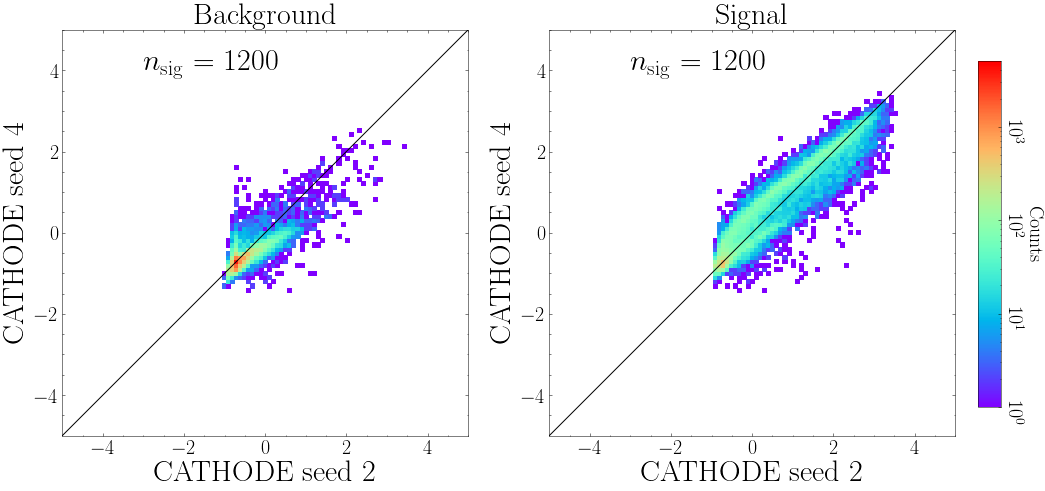

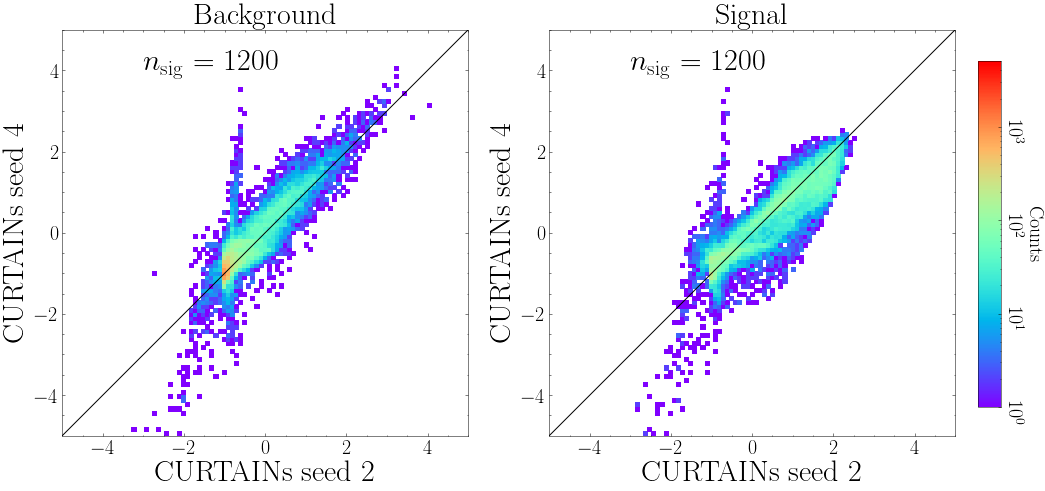

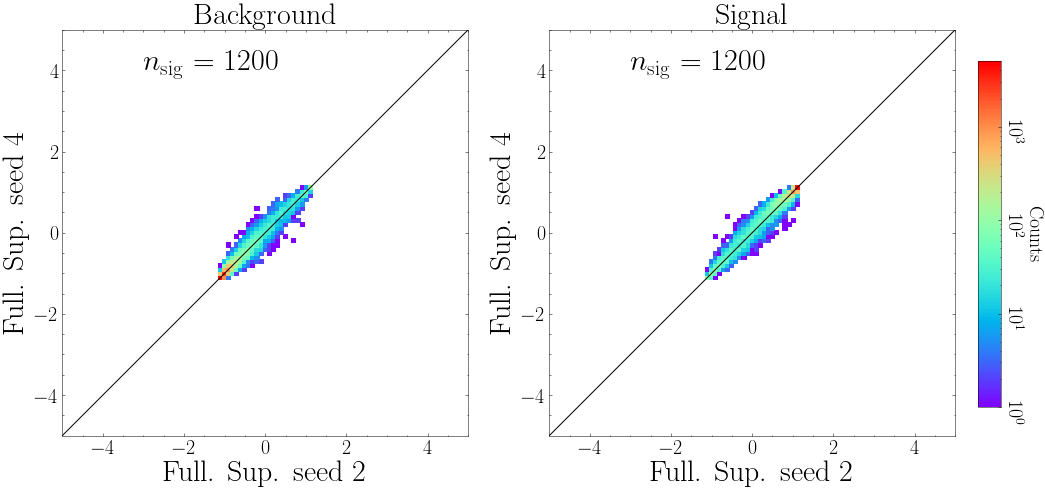

KeyError: 'combined'

In [16]:

seed_1 = 2
seed_2 = 4



fig = make_plot(all_results_bkg["feta"][seed_1], all_results_bkg["feta"][seed_2], 
          all_results_sig["feta"][seed_1], all_results_sig["feta"][seed_2], 
          f"FETA seed {seed_1}", f"FETA seed {seed_2}")
fig.savefig(f"paper_plots/feta_v_feta_{num_signal_to_inject}.pdf", dpi = dpi)


fig = make_plot(all_results_bkg["cathode"][seed_1], all_results_bkg["cathode"][seed_2], 
          all_results_sig["cathode"][seed_1], all_results_sig["cathode"][seed_2], 
          f"CATHODE seed {seed_1}", f"CATHODE seed {seed_2}")
fig.savefig(f"paper_plots/cathode_v_cathode_{num_signal_to_inject}.pdf", dpi = dpi)


fig = make_plot(all_results_bkg["curtains"][seed_1], all_results_bkg["curtains"][seed_2], 
          all_results_sig["curtains"][seed_1], all_results_sig["curtains"][seed_2], 
          f"CURTAINs seed {seed_1}", f"CURTAINs seed {seed_2}")
fig.savefig(f"paper_plots/curtains_v_curtains_{num_signal_to_inject}.pdf", dpi = dpi)



fig = make_plot(all_results_bkg["fullsup"][seed_1], all_results_bkg["fullsup"][seed_2], 
          all_results_sig["fullsup"][seed_1], all_results_sig["fullsup"][seed_2], 
          f"Full. Sup. seed {seed_1}", f"Full. Sup. seed {seed_2}")
fig.savefig(f"paper_plots/fullsup_v_fullsup{num_signal_to_inject}.pdf", dpi = dpi)



make_plot(all_results_bkg["combined"][seed_1], all_results_bkg["combined"][seed_2], 
          all_results_sig["combined"][seed_1], all_results_sig["combined"][seed_2], 
          f"Combined seed {seed_1}", f"Combined seed {seed_2}")


## Get fraction of shared events

In [29]:
# Load in the data


num_signal_to_inject = 1200

synth_ids = ["feta", "cathode", "curtains", "fullsup"]#, "combined"]

all_results_bkg = {iid:{} for iid in synth_ids}
all_results_sig = {iid:{} for iid in synth_ids}


def standardize(x):
    return (x - np.mean(x))/np.std(x)

n_seed = 5

for iid in synth_ids:
    for seed_NN in range(n_seed):
        
        if iid != "fullsup":
            data = np.load(f"{scatterplot_dir}/{iid}_results_seedNN{seed_NN}_nsig{num_signal_to_inject}.npy")
        else:
            data = np.load(f"{scatterplot_dir}/full_sup_results_seedNN{seed_NN}.npy")
        
        # currently standardizing each random seed independently. May want to revisit!
        data_stand = standardize(data)
        data_bkg = data_stand[:20000]
        data_sig = data_stand[20000:]
        
        all_results_bkg[iid][seed_NN] = data_bkg
        all_results_sig[iid][seed_NN] = data_sig
        
        
# concatenate results

concatenated_results_bkg = {iid:0 for iid in synth_ids}
concatenated_results_all = {iid:0 for iid in synth_ids} # not just sig!!


for iid in synth_ids:
    loc_holder_bkg = np.empty((0, 1))
    loc_holder_all = np.empty((0, 1))
    
    for seed_NN in range(n_seed):
        loc_holder_bkg = np.concatenate((loc_holder_bkg, all_results_bkg[iid][seed_NN]), axis = 0)
        
        #loc_holder_all = np.concatenate((loc_holder_all, all_results_bkg[iid][seed_NN]), axis = 0)
        loc_holder_all = np.concatenate((loc_holder_all, all_results_sig[iid][seed_NN]), axis = 0)
        
    concatenated_results_bkg[iid] = loc_holder_bkg
    concatenated_results_all[iid] = loc_holder_all

    

In [30]:
def get_highest_percentile(scores, num_ids_to_take):
    
    # array to keep track of the id
    ids = np.arange(len(scores))
    
    # sort the ids by the scores
    sorted_ids = [x for _,x in sorted(zip(scores,ids))]

    # return the highest ids
    return(sorted_ids[-num_ids_to_take:])



In [31]:


all_overlap_bkg = []
feta_cathode_overlap_bkg, cathode_curtains_overlap_bkg, curtains_feta_overlap_bkg = [], [], []

all_overlap_all = []
feta_cathode_overlap_all, cathode_curtains_overlap_all, curtains_feta_overlap_all = [], [], []

percentiles = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for p in percentiles:
    
    # background
    num_ids_to_take_bkg = int(p*concatenated_results_bkg["feta"].shape[0])
    print(f"Taking the top {num_ids_to_take_bkg} scores ({p} percentile)")
    
    feta_ids_bkg = get_highest_percentile(concatenated_results_bkg["feta"].flatten(), num_ids_to_take_bkg)
    cathode_ids_bkg = get_highest_percentile(concatenated_results_bkg["cathode"].flatten(), num_ids_to_take_bkg)
    curtains_ids_bkg = get_highest_percentile(concatenated_results_bkg["curtains"].flatten(), num_ids_to_take_bkg)
    fullsup_ids_bkg = get_highest_percentile(concatenated_results_bkg["fullsup"].flatten(), num_ids_to_take_bkg)
    
    feta_cathode_bkg = list(set(feta_ids_bkg) & set(cathode_ids_bkg))
    cathode_curtains_bkg = list(set(cathode_ids_bkg) & set(curtains_ids_bkg))
    curtains_feta_bkg = list(set(curtains_ids_bkg) & set(feta_ids_bkg))
    
    grand_uni_bkg = list(set(feta_ids_bkg) & set(cathode_ids_bkg) & set(curtains_ids_bkg))
    
    all_overlap_bkg.append(float(len(grand_uni_bkg))/num_ids_to_take_bkg)
    feta_cathode_overlap_bkg.append(float(len(feta_cathode_bkg))/num_ids_to_take_bkg)
    cathode_curtains_overlap_bkg.append(float(len(cathode_curtains_bkg))/num_ids_to_take_bkg)
    curtains_feta_overlap_bkg.append(float(len(curtains_feta_bkg))/num_ids_to_take_bkg)
    
    # all
    num_ids_to_take_all = int(p*concatenated_results_all["feta"].shape[0])
    print(f"Taking the top {num_ids_to_take_all} scores ({p} percentile)")
    
    feta_ids_all = get_highest_percentile(concatenated_results_all["feta"].flatten(), num_ids_to_take_all)
    cathode_ids_all = get_highest_percentile(concatenated_results_all["cathode"].flatten(), num_ids_to_take_all)
    curtains_ids_all = get_highest_percentile(concatenated_results_all["curtains"].flatten(), num_ids_to_take_all)
    fullsup_ids_all = get_highest_percentile(concatenated_results_all["fullsup"].flatten(), num_ids_to_take_all)
    
    feta_cathode_all = list(set(feta_ids_all) & set(cathode_ids_all))
    cathode_curtains_all = list(set(cathode_ids_all) & set(curtains_ids_all))
    curtains_feta_all = list(set(curtains_ids_all) & set(feta_ids_all))
    
    grand_uni_all = list(set(feta_ids_all) & set(cathode_ids_all) & set(curtains_ids_all))
    
    all_overlap_all.append(float(len(grand_uni_all))/num_ids_to_take_all)
    feta_cathode_overlap_all.append(float(len(feta_cathode_all))/num_ids_to_take_all)
    cathode_curtains_overlap_all.append(float(len(cathode_curtains_all))/num_ids_to_take_all)
    curtains_feta_overlap_all.append(float(len(curtains_feta_all))/num_ids_to_take_all)
    
    



Taking the top 500 scores (0.005 percentile)
Taking the top 500 scores (0.005 percentile)
Taking the top 1000 scores (0.01 percentile)
Taking the top 1000 scores (0.01 percentile)
Taking the top 5000 scores (0.05 percentile)
Taking the top 5000 scores (0.05 percentile)
Taking the top 10000 scores (0.1 percentile)
Taking the top 10000 scores (0.1 percentile)
Taking the top 20000 scores (0.2 percentile)
Taking the top 20000 scores (0.2 percentile)
Taking the top 30000 scores (0.3 percentile)
Taking the top 30000 scores (0.3 percentile)
Taking the top 40000 scores (0.4 percentile)
Taking the top 40000 scores (0.4 percentile)
Taking the top 50000 scores (0.5 percentile)
Taking the top 50000 scores (0.5 percentile)
Taking the top 60000 scores (0.6 percentile)
Taking the top 60000 scores (0.6 percentile)
Taking the top 70000 scores (0.7 percentile)
Taking the top 70000 scores (0.7 percentile)
Taking the top 80000 scores (0.8 percentile)
Taking the top 80000 scores (0.8 percentile)
Taking the

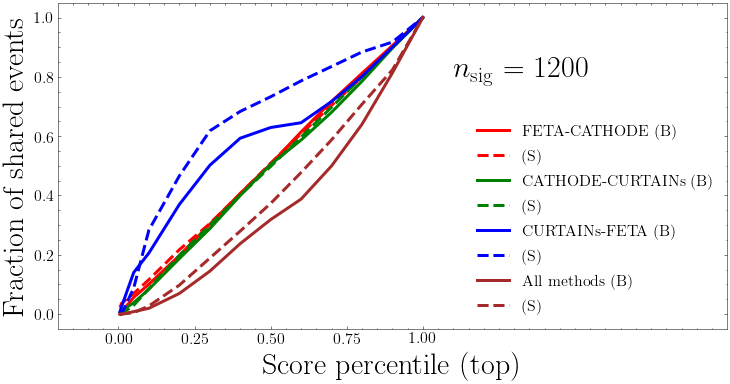

In [32]:
fontsize = 30
small_font = 16

l = 3


fig = plt.figure(figsize = (12, 6))


plt.plot(percentiles, feta_cathode_overlap_bkg, label = "FETA-CATHODE (B)", linewidth = l, color = "red")
plt.plot(percentiles, feta_cathode_overlap_all, label = "(S)", linewidth = l, color = "red", linestyle = "dashed")

plt.plot(percentiles, cathode_curtains_overlap_bkg, label = "CATHODE-CURTAINs (B)", linewidth = l, color = "green")
plt.plot(percentiles, cathode_curtains_overlap_all, label = "(S)", linewidth = l, color = "green", linestyle = "dashed")

plt.plot(percentiles, curtains_feta_overlap_bkg, label = "CURTAINs-FETA (B)", linewidth = l, color = "blue")
plt.plot(percentiles, curtains_feta_overlap_all, label = "(S)", linewidth = l, color = "blue", linestyle = "dashed")

plt.plot(percentiles, all_overlap_bkg, label = "All methods (B)", linewidth = l, color = "brown")
plt.plot(percentiles, all_overlap_all, label = "(S)", linewidth = l, color = "brown", linestyle = "dashed")


plt.xlim(-.2, 2)
plt.legend(fontsize = small_font, loc = "lower right")
#plt.yscale("log")
plt.xlabel("Score percentile (top)", fontsize = fontsize)
plt.ylabel("Fraction of shared events", fontsize = fontsize)
#plt.title(f"Trained on {num_signal_to_inject} injected signal, evaluated on bkg")
plt.xticks(ticks=[0, 0.25, 0.5, .75, 1])
plt.tick_params(axis='both', which='major', labelsize=small_font)
plt.text(1.1, 0.8, f"$n_\\mathrm{{sig}}$ = {num_signal_to_inject}", fontsize = fontsize)
plt.show()

fig.savefig(f"paper_plots/unification_{num_signal_to_inject}.pdf", dpi = dpi)
